# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import random
import time
import torch

from collections import deque
from ddpg_agent import Agent
from unityagents import UnityEnvironment

In [2]:
torch.__version__

'1.1.0'

In [3]:
torch.version.cuda

'9.0'

In [4]:
SEED = 1

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [5]:
reacherpath='Reacher_Windows_x86_64/Reacher.exe'

In [6]:
env = UnityEnvironment(file_name=reacherpath)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [7]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [8]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
# print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33


In [9]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=SEED)

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

## DDPG function

Inside the agent.step function LEARN_NUM (10) passes are performed at LEARN_EVERY (20) timestep intervals. 

**Accumulate_option** is used to toggle the accumulation of model scores either inside the agent.step, or here in the DDPG function calling into step each time, or as a separate call to add to the Agent memory (i.e. outside of step). 

If accumulation is performed in the agent.step then agent.step is called only once per timestep - the agent.step assembles the models into memory once per timestep. 

If accumulation is performed in the DDPG function, using a zip over all 20 models and calling agent.step for each, then each timestep has 20 times more calls to agent.step and therefore the Agent can perform more learning passes. Consequently, an episode can potentially be up to 20 times slower. But as scoring is counted per episode it is counted as solving the environment earlier, even though in fact it takes much longer to solve. 

If accumulation is performed via a seperate call to add to Agent memory then it has a similar effect to accumulating within agent.step, but splitting the memory accumulation from the learning process did produce a faster convergence.

After completing these approaches, these were the times to complete when accumulating to memory via agent.step, or from the DDPG via step, or with a split approach: 13.7 hours compared to 1.8 hours for the same model and activation settings, which was 7.7 times longer. 

The best model utilized a leaky_relu and ran even faster at 67 minutes, utilizing the separate call approach, but a comparison with the inefficient appraoch was not made with these settings... 

In [10]:
accumlate_options = ["inside step", "from ddpg", "split"]

In [11]:
accumulate_option = accumlate_options[2]
print(accumulate_option)

split


In [12]:
# Set up outside ddpg, in case we abort we can still chart...
mean_scores = []                               
moving_avgs = []

In [13]:
def ddpg(n_episodes=1000, max_t=1000, print_every=10, score_target=30.01, score_window=100):
    
    global mean_scores, moving_avgs
    mean_scores = []
    moving_avgs = []
    best_score  = -np.inf
    scores_deque = deque(maxlen=score_window)                 # mean scores from most recent episodes - target is 100
    
    sectionstarting = time.time()
    
    for i_episode in range(1, n_episodes+1):                  
        env_info = env.reset(train_mode=True)[brain_name]      # reset environment
        states = env_info.vector_observations                  # get current state for each agent
        escore = np.zeros(num_agents)                          # initialize the score (for each agent)
        agent.reset()
        startingtime = time.time()
        
        for t in range(max_t):
            actions = agent.act(states, add_noise=True)        # select an action (for each agent)
            env_info = env.step(actions)[brain_name]           # send all actions to the environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            
            if accumulate_option == "inside step":
# Pass in the components and assemble / accumulate into memory inside the agent.step...
# Much faster, but takes more episodes 
                agent.step(states, actions, rewards, next_states, dones, t, num_agents, accumulate=True)
# Accumulate here approach - assemble agents components and call step on each
# Over seven times slower!... 
            elif accumulate_option == "from ddpg":
                for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                    agent.step(state, action, reward, next_state, done, t, num_agents, accumulate=False)
            else:
# Accumulate via splitting calls to memory assembling and learning (i.e. invoke separate components)
                for i in range(num_agents):
                    agent.add_to_memory(states[i], actions[i], rewards[i], next_states[i], dones[i])
            
                agent.learn_from_memory(t)
            
            states = next_states
            escore += rewards                                   # update the episode score (for each agent)
            if np.any(dones):
                break
                
        timetaken = int(round(time.time() - startingtime, 0))
        
        mean_escore = np.mean(escore)                          # mean of episode scores
        
        mean_scores.append(mean_escore)                        # save episode mean score
        scores_deque.append(mean_scores[-1])                   # save mean score to window of latest scores
        moving_avgs.append(np.mean(scores_deque))              # also save moving average
            
        print('\rEpisode {} ({} sec)\tCurrent Score: {:.2f}\tMean Score: {:.2f}\tMoving Average Score: {:.2f}'.format(i_episode, timetaken, mean_escore, mean_scores[-1], moving_avgs[-1]), end="")
        
        if i_episode % print_every == 0:
            last_every_avg = np.mean(mean_scores[- print_every])
            sectiontaken = int(round(time.time() - sectionstarting, 0))
            sectionstarting = time.time()
            print('\rEpisode {} ({} sec)\tCurrent Score: {:.2f}\tMean Score: {:.2f}\tMoving Average Score: {:.2f}'.format(i_episode, sectiontaken, mean_escore, last_every_avg, moving_avgs[-1]))

        if mean_escore > best_score:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            best_score = mean_escore
            
        if moving_avgs[-1] >= score_target and i_episode >= score_window:
            print('\nEnvironment solved in {} episodes!\tAverage Score: {:.2f}'.format(i_episode-score_window, moving_avgs[-1]))
            torch.save(agent.actor_local.state_dict(), 'final_checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'final_checkpoint_critic.pth')
            break
            
    return mean_scores, moving_avgs

In [14]:
start = time.time()

run_scores, run_avgs = ddpg()

end = time.time()
elapsed = (end - start) / 60.0 
print("\nElapsed Time: {0:3.2f} mins.".format(elapsed))

Episode 10 (240 sec)	Current Score: 1.06	Mean Score: 0.72	Moving Average Score: 0.87
Episode 20 (243 sec)	Current Score: 0.87	Mean Score: 0.30	Moving Average Score: 0.81
Episode 30 (250 sec)	Current Score: 2.07	Mean Score: 1.34	Moving Average Score: 1.00
Episode 40 (261 sec)	Current Score: 4.28	Mean Score: 1.63	Moving Average Score: 1.46
Episode 50 (272 sec)	Current Score: 7.77	Mean Score: 4.22	Moving Average Score: 2.27
Episode 60 (285 sec)	Current Score: 12.59	Mean Score: 7.00	Moving Average Score: 3.41
Episode 70 (302 sec)	Current Score: 19.57	Mean Score: 13.62	Moving Average Score: 5.23
Episode 80 (301 sec)	Current Score: 28.52	Mean Score: 23.10	Moving Average Score: 7.67
Episode 90 (277 sec)	Current Score: 33.91	Mean Score: 31.55	Moving Average Score: 10.45
Episode 100 (272 sec)	Current Score: 37.50	Mean Score: 35.69	Moving Average Score: 13.01
Episode 110 (273 sec)	Current Score: 37.71	Mean Score: 37.19	Moving Average Score: 16.67
Episode 120 (274 sec)	Current Score: 37.94	Mean S

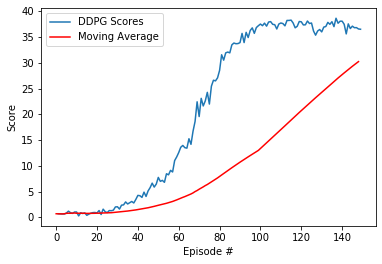

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(run_scores)+1), run_scores, label='DDPG Scores')
plt.plot(np.arange(len(run_scores)), run_avgs, c='r', label='Moving Average')
plt.title="Score when accumulating memory separately from learning"
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left')

plt.show()

### Best Run Scores:
- **Run 14 was the best run!**
- leaky_relu
- gradient clipping = 1.0, batch_size=128, SIGMA = 0.2, LR_ACTOR, LR_CRITIC = 1e-3, BATCH NORM on FC1 ACTOR and FCS1 CRITIC
- accumulate memory separately from the learning  

```
Episode 10 (240 sec)	Current Score: 1.06	Mean Score: 0.72	Moving Average Score: 0.87
Episode 20 (243 sec)	Current Score: 0.87	Mean Score: 0.30	Moving Average Score: 0.81
Episode 30 (250 sec)	Current Score: 2.07	Mean Score: 1.34	Moving Average Score: 1.00
Episode 40 (261 sec)	Current Score: 4.28	Mean Score: 1.63	Moving Average Score: 1.46
Episode 50 (272 sec)	Current Score: 7.77	Mean Score: 4.22	Moving Average Score: 2.27
Episode 60 (285 sec)	Current Score: 12.59	Mean Score: 7.00	Moving Average Score: 3.41
Episode 70 (302 sec)	Current Score: 19.57	Mean Score: 13.62	Moving Average Score: 5.23
Episode 80 (301 sec)	Current Score: 28.52	Mean Score: 23.10	Moving Average Score: 7.67
Episode 90 (277 sec)	Current Score: 33.91	Mean Score: 31.55	Moving Average Score: 10.45
Episode 100 (272 sec)	Current Score: 37.50	Mean Score: 35.69	Moving Average Score: 13.01
Episode 110 (273 sec)	Current Score: 37.71	Mean Score: 37.19	Moving Average Score: 16.67
Episode 120 (274 sec)	Current Score: 37.94	Mean Score: 37.60	Moving Average Score: 20.36
Episode 130 (274 sec)	Current Score: 35.98	Mean Score: 37.34	Moving Average Score: 23.90
Episode 140 (275 sec)	Current Score: 38.06	Mean Score: 36.91	Moving Average Score: 27.38
Episode 149 (27 sec)	Current Score: 36.50	Mean Score: 36.50	Moving Average Score: 30.22
Environment solved in 49 episodes!	Average Score: 30.22

Elapsed Time: 67.44 mins.
```
<img src="images/run_14.PNG" align="left"/>

----

### Watch the smart agent

In [16]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [17]:
env_info = env.reset(train_mode=False)[brain_name]
states = env_info.vector_observations
scores = np.zeros(num_agents) 
episode = 0

while True:
    actions = agent.act(states, add_noise=False)
    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations
    rewards = env_info.rewards
    dones = env_info.local_done
    scores += env_info.rewards
    states = next_states  
    episode += 1
  
    if np.any(dones): 
        break 

print('Episodes: {}; Average Score: {}'.
              format(episode, np.mean(scores)))    

Episodes: 1001; Average Score: 39.285999121889475


In [18]:
env.close()

# Appendix

## Other successful runs

**Run 15 Scores:**
- leaky_relu
- kaiming_normal weight initialization
- gradient clipping = 1.0, batch_size=128, SIGMA = 0.2, LR_ACTOR, LR_CRITIC = 1e-3, BATCH NORM on FC1 ACTOR and FCS1 CRITIC
- accumulate memory separately from the learning  

```
Episode 10 (265 sec)	Current Score: 0.76	Mean Score: 0.06	Moving Average Score: 0.26
Episode 20 (267 sec)	Current Score: 1.10	Mean Score: 0.82	Moving Average Score: 0.60
Episode 30 (273 sec)	Current Score: 1.28	Mean Score: 1.03	Moving Average Score: 0.80
Episode 40 (285 sec)	Current Score: 2.17	Mean Score: 1.78	Moving Average Score: 1.06
Episode 50 (291 sec)	Current Score: 3.03	Mean Score: 1.59	Moving Average Score: 1.32
Episode 60 (296 sec)	Current Score: 3.84	Mean Score: 3.10	Moving Average Score: 1.65
Episode 70 (295 sec)	Current Score: 5.30	Mean Score: 4.23	Moving Average Score: 2.16
Episode 80 (297 sec)	Current Score: 7.84	Mean Score: 7.12	Moving Average Score: 2.83
Episode 90 (296 sec)	Current Score: 15.28	Mean Score: 9.88	Moving Average Score: 4.06
Episode 100 (296 sec)	Current Score: 21.27	Mean Score: 17.22	Moving Average Score: 5.69
Episode 110 (295 sec)	Current Score: 32.92	Mean Score: 25.24	Moving Average Score: 8.47
Episode 120 (296 sec)	Current Score: 38.07	Mean Score: 33.13	Moving Average Score: 11.96
Episode 130 (296 sec)	Current Score: 38.82	Mean Score: 37.69	Moving Average Score: 15.72
Episode 140 (297 sec)	Current Score: 39.12	Mean Score: 38.48	Moving Average Score: 19.41
Episode 150 (296 sec)	Current Score: 39.13	Mean Score: 38.28	Moving Average Score: 23.06
Episode 160 (297 sec)	Current Score: 38.63	Mean Score: 38.78	Moving Average Score: 26.61
Episode 170 (296 sec)	Current Score: 38.36	Mean Score: 38.36	Moving Average Score: 29.97
Episode 171 (30 sec)	Current Score: 38.60	Mean Score: 38.60	Moving Average Score: 30.28
Environment solved in 71 episodes!	Average Score: 30.28

Elapsed Time: 82.71 mins.
```
<img src="images/run_15.PNG" align="left"/>

**Run 13 Scores:**
- gradient clipping = 1.0, batch_size=128, SIGMA = 0.2, LR_ACTOR, LR_CRITIC = 1e-3, BATCH NORM on FC1 ACTOR and FCS1 CRITIC
- fixed scoring technique
- accumulate memory separately from the learning  

```
Episode 10 (244 sec)	Current Score: 0.98	Mean Score: 0.72	Moving Average Score: 0.73
Episode 20 (257 sec)	Current Score: 1.40	Mean Score: 0.93	Moving Average Score: 0.92
Episode 30 (269 sec)	Current Score: 3.36	Mean Score: 1.74	Moving Average Score: 1.51
Episode 40 (268 sec)	Current Score: 4.34	Mean Score: 3.93	Moving Average Score: 2.20
Episode 50 (276 sec)	Current Score: 6.27	Mean Score: 5.29	Moving Average Score: 2.89
Episode 60 (295 sec)	Current Score: 7.98	Mean Score: 7.10	Moving Average Score: 3.59
Episode 70 (282 sec)	Current Score: 8.26	Mean Score: 7.60	Moving Average Score: 4.12
Episode 80 (289 sec)	Current Score: 9.37	Mean Score: 8.88	Moving Average Score: 4.776
Episode 90 (270 sec)	Current Score: 10.47	Mean Score: 9.60	Moving Average Score: 5.32
Episode 100 (272 sec)	Current Score: 12.47	Mean Score: 10.18	Moving Average Score: 5.90
Episode 110 (275 sec)	Current Score: 12.56	Mean Score: 11.63	Moving Average Score: 7.14
Episode 120 (273 sec)	Current Score: 13.87	Mean Score: 12.71	Moving Average Score: 8.36
Episode 130 (276 sec)	Current Score: 20.23	Mean Score: 14.63	Moving Average Score: 9.76
Episode 140 (292 sec)	Current Score: 27.24	Mean Score: 21.67	Moving Average Score: 11.80
Episode 150 (287 sec)	Current Score: 31.91	Mean Score: 26.45	Moving Average Score: 14.09
Episode 160 (289 sec)	Current Score: 35.21	Mean Score: 28.80	Moving Average Score: 16.55
Episode 170 (275 sec)	Current Score: 35.56	Mean Score: 34.73	Moving Average Score: 19.35
Episode 180 (274 sec)	Current Score: 35.01	Mean Score: 34.07	Moving Average Score: 21.98
Episode 190 (273 sec)	Current Score: 36.65	Mean Score: 33.93	Moving Average Score: 24.49
Episode 200 (273 sec)	Current Score: 36.76	Mean Score: 36.92	Moving Average Score: 27.08
Episode 210 (286 sec)	Current Score: 37.53	Mean Score: 37.89	Moving Average Score: 29.53
Episode 213 (28 sec)	Current Score: 37.72	Mean Score: 37.72	Moving Average Score: 30.23
Environment solved in 113 episodes!	Average Score: 30.23

Elapsed Time: 98.03 mins.
```    
<img src="images/run_13.PNG" align="left"/>

**Run 12 Scores:**

- gradient clipping = 1.0, batch_size=128, SIGMA = 0.2, LR_ACTOR, LR_CRITIC = 1e-3, BATCH NORM on FC1 ACTOR and FCS1 CRITIC
- accumulate in the DDPG function  

```
Episode 10 (3820 sec)	Current Score: 2.97	Mean Score: 0.43	Moving Average Score: 2.06
Episode 20 (3991 sec)	Current Score: 6.95	Mean Score: 4.28	Moving Average Score: 4.24
Episode 30 (3960 sec)	Current Score: 9.10	Mean Score: 9.15	Moving Average Score: 5.972
Episode 40 (4048 sec)	Current Score: 15.29	Mean Score: 10.23	Moving Average Score: 8.10
Episode 50 (4219 sec)	Current Score: 26.95	Mean Score: 16.86	Moving Average Score: 10.79
Episode 60 (4169 sec)	Current Score: 33.81	Mean Score: 26.74	Moving Average Score: 14.19
Episode 70 (4154 sec)	Current Score: 37.13	Mean Score: 34.10	Moving Average Score: 17.13
Episode 80 (4351 sec)	Current Score: 38.19	Mean Score: 37.16	Moving Average Score: 19.76
Episode 90 (4284 sec)	Current Score: 39.09	Mean Score: 38.27	Moving Average Score: 21.90
Episode 100 (4291 sec)	Current Score: 39.00	Mean Score: 39.30	Moving Average Score: 23.57
Episode 110 (4214 sec)	Current Score: 37.60	Mean Score: 38.54	Moving Average Score: 27.20
Episode 119 (452 sec)	Current Score: 38.24	Mean Score: 38.24	Moving Average Score: 30.05
Environment solved in 19 episodes!	Average Score: 30.05

Elapsed Time: 823.30 mins.
```
<img src="images/run_12.PNG" align="left"/>

In [20]:
print("Times to complete when accumulating to memory in the DDPG function compared to in the Agent:")
print("{:.1f} hours compared to {:.1f} hours, which was {:.1f} times longer".format((823/60), (107/60), (823/107)))

Times to complete when accumulating to memory in the DDPG function compared to in the Agent:
13.7 hours compared to 1.8 hours, which was 7.7 times longer


**Run 11 Scores:**
- gradient clipping = 1.0, batch_size=128, SIGMA = 0.2, LR_ACTOR, LR_CRITIC = 1e-3, BATCH NORM on FC1 ACTOR and FCS1 CRITIC
- fixed the scoring technique for this and subsequent runs...
- accumulate in the Agent step   

```
Episode 10 (253 sec)	Current Score: 1.24	Mean Score: 1.06	Moving Average Score: 0.96
Episode 20 (250 sec)	Current Score: 2.34	Mean Score: 1.31	Moving Average Score: 1.51
Episode 30 (256 sec)	Current Score: 3.00	Mean Score: 2.17	Moving Average Score: 1.99
Episode 40 (260 sec)	Current Score: 3.50	Mean Score: 3.65	Moving Average Score: 2.32
Episode 50 (260 sec)	Current Score: 6.23	Mean Score: 4.22	Moving Average Score: 2.85
Episode 60 (261 sec)	Current Score: 6.96	Mean Score: 5.75	Moving Average Score: 3.49
Episode 70 (260 sec)	Current Score: 6.04	Mean Score: 6.95	Moving Average Score: 3.98
Episode 80 (260 sec)	Current Score: 7.19	Mean Score: 6.46	Moving Average Score: 4.30
Episode 90 (260 sec)	Current Score: 6.69	Mean Score: 8.17	Moving Average Score: 4.61
Episode 100 (261 sec)	Current Score: 8.59	Mean Score: 7.32	Moving Average Score: 4.92
Episode 110 (260 sec)	Current Score: 10.11	Mean Score: 7.53	Moving Average Score: 5.68
Episode 120 (260 sec)	Current Score: 8.70	Mean Score: 8.58	Moving Average Score: 6.417
Episode 130 (261 sec)	Current Score: 12.50	Mean Score: 9.00	Moving Average Score: 7.14
Episode 140 (261 sec)	Current Score: 12.99	Mean Score: 11.90	Moving Average Score: 8.02
Episode 150 (260 sec)	Current Score: 12.36	Mean Score: 11.89	Moving Average Score: 8.79
Episode 160 (260 sec)	Current Score: 16.78	Mean Score: 14.49	Moving Average Score: 9.61
Episode 170 (260 sec)	Current Score: 21.29	Mean Score: 15.43	Moving Average Score: 10.76
Episode 180 (262 sec)	Current Score: 26.88	Mean Score: 21.41	Moving Average Score: 12.54
Episode 190 (260 sec)	Current Score: 31.71	Mean Score: 26.36	Moving Average Score: 14.82
Episode 200 (261 sec)	Current Score: 35.19	Mean Score: 31.27	Moving Average Score: 17.39
Episode 210 (260 sec)	Current Score: 36.78	Mean Score: 34.80	Moving Average Score: 20.07
Episode 220 (260 sec)	Current Score: 38.58	Mean Score: 35.86	Moving Average Score: 22.88
Episode 230 (260 sec)	Current Score: 37.48	Mean Score: 38.27	Moving Average Score: 25.59
Episode 240 (260 sec)	Current Score: 38.24	Mean Score: 37.17	Moving Average Score: 28.10
Episode 248 (27 sec)	Current Score: 37.96	Mean Score: 37.96	Moving Average Score: 30.14
Environment solved in 148 episodes!	Average Score: 30.14

Elapsed Time: 107.39 mins.
```
<img src="images/run_11.PNG" align="left"/>

## Unsuccesful runs

**Run 10 Scores:**
- gradient clipping = 1.0, batch_size=1024, SIGMA = 0.2, LR_ACTOR = 1e-4, LR_CRITIC = 1e-3, BATCH NORM on FC1 ACTOR and FCS1 CRITIC
- Accumulating in the DDPG function - took 15.5 hours to get here! 
```
Episode 10	Current Score: 1.66	Average Score: 0.26
Episode 20	Current Score: 2.34	Average Score: 1.59
Episode 30	Current Score: 4.85	Average Score: 2.73
Episode 40	Current Score: 11.82	Average Score: 4.44
Episode 50	Current Score: 13.92	Average Score: 11.97
Episode 60	Current Score: 14.77	Average Score: 15.28
Episode 70	Current Score: 16.92	Average Score: 17.11
Episode 80	Current Score: 19.18	Average Score: 17.96
Episode 90	Current Score: 18.24	Average Score: 18.96
Episode 100	Current Score: 18.64	Average Score: 19.05
Episode 110	Current Score: 17.72	Average Score: 18.33
Episode 120	Current Score: 19.37	Average Score: 18.78
Episode 130	Current Score: 17.19	Average Score: 19.03
Episode 137	Current Score: 18.69	Average Score: 18.40
```

**Run 9 Scores:**
- gradient clipping = 1.0, batch_size=1024, SIGMA = 0.2, LR_ACTOR = 1e-4, LR_CRITIC = 1e-3, BATCH NORM on FC1 ACTOR and FCS1 CRITIC
- NO accumulation strategy
```
Episode 10	Current Score: 0.03	Average Score: 0.01
Episode 20	Current Score: 0.18	Average Score: 0.04
Episode 30	Current Score: 0.24	Average Score: 0.14
Episode 40	Current Score: 0.50	Average Score: 0.41
Episode 50	Current Score: 0.43	Average Score: 0.35
Episode 60	Current Score: 0.62	Average Score: 0.53
Episode 70	Current Score: 0.51	Average Score: 0.48
Episode 80	Current Score: 1.04	Average Score: 0.75
Episode 90	Current Score: 0.83	Average Score: 1.13
Episode 100	Current Score: 1.13	Average Score: 0.96
Episode 110	Current Score: 1.31	Average Score: 0.75
Episode 120	Current Score: 1.11	Average Score: 1.22
Episode 130	Current Score: 1.57	Average Score: 1.50
Episode 137	Current Score: 1.45	Average Score: 1.44
```

**Run 8 Scores:**
- gradient clipping = 1.0, batch_size=512, SIGMA = 0.2, LR_ACTOR, LR_CRITIC = 1e-3, BATCH NORM on FC1 ACTOR and FCS1 CRITIC
- delayed network updates

```
Episode 10	Current Score: 0.32	Average Score: 0.33
Episode 20	Current Score: 1.12	Average Score: 0.39
Episode 30	Current Score: 1.40	Average Score: 1.30
Episode 40	Current Score: 3.64	Average Score: 1.20
Episode 50	Current Score: 7.05	Average Score: 2.57
Episode 60	Current Score: 9.91	Average Score: 7.48
Episode 70	Current Score: 14.25	Average Score: 11.18
Episode 80	Current Score: 18.09	Average Score: 15.18
Episode 90	Current Score: 18.66	Average Score: 17.94
Episode 100	Current Score: 19.21	Average Score: 18.76
Episode 110	Current Score: 18.87	Average Score: 19.06
Episode 120	Current Score: 19.12	Average Score: 19.40
Episode 130	Current Score: 19.32	Average Score: 19.12
Episode 140	Current Score: 19.48	Average Score: 19.54
Episode 150	Current Score: 19.35	Average Score: 19.48
Episode 160	Current Score: 19.43	Average Score: 19.48
Episode 170	Current Score: 19.50	Average Score: 19.43
Episode 180	Current Score: 19.53	Average Score: 19.50
Episode 190	Current Score: 19.47	Average Score: 19.54
Episode 200	Current Score: 19.54	Average Score: 19.57
Episode 210	Current Score: 19.44	Average Score: 19.56
Episode 220	Current Score: 18.99	Average Score: 19.54
Episode 230	Current Score: 19.23	Average Score: 18.83
Episode 240	Current Score: 19.49	Average Score: 19.27
Episode 250	Current Score: 19.53	Average Score: 19.40
Episode 260	Current Score: 19.49	Average Score: 19.04
Episode 270	Current Score: 19.26	Average Score: 19.54
Episode 280	Current Score: 19.35	Average Score: 19.11
Episode 290	Current Score: 19.17	Average Score: 19.01
Episode 300	Current Score: 19.42	Average Score: 19.52
Episode 310	Current Score: 19.27	Average Score: 19.45
Episode 320	Current Score: 19.50	Average Score: 19.41
Episode 330	Current Score: 19.43	Average Score: 19.44
Episode 340	Current Score: 19.50	Average Score: 19.51
Episode 350	Current Score: 19.29	Average Score: 19.30
Episode 360	Current Score: 19.22	Average Score: 19.42
Episode 370	Current Score: 19.10	Average Score: 19.42
Episode 380	Current Score: 19.29	Average Score: 19.12
Episode 390	Current Score: 19.34	Average Score: 19.53
Episode 400	Current Score: 19.44	Average Score: 19.49
Episode 410	Current Score: 19.45	Average Score: 19.27
Episode 420	Current Score: 19.48	Average Score: 19.37
Episode 430	Current Score: 19.37	Average Score: 19.41
Episode 440	Current Score: 19.38	Average Score: 19.41
Episode 450	Current Score: 19.14	Average Score: 19.38
Episode 460	Current Score: 19.40	Average Score: 19.15
Episode 470	Current Score: 18.92	Average Score: 19.03
Episode 480	Current Score: 19.47	Average Score: 19.26
Episode 490	Current Score: 19.41	Average Score: 19.47
Episode 500	Current Score: 19.37	Average Score: 19.30
Episode 510	Current Score: 19.45	Average Score: 19.20
Episode 520	Current Score: 19.48	Average Score: 19.26
Episode 530	Current Score: 19.48	Average Score: 19.33
Episode 540	Current Score: 19.32	Average Score: 19.14
Episode 550	Current Score: 19.32	Average Score: 19.22
Episode 556	Current Score: 19.13	Average Score: 19.24
```        

**Run 7 Scores:**
- gradient clipping = 1.0, batch_size=512, SIGMA = 0.05, LR_ACTOR, LR_CRITIC = 1e-3, BATCH NORM on FC1 ACTOR and FCS1 CRITIC
- delayed network updates

```
Episode 10	Current Score: 0.32	Average Score: 0.30
Episode 20	Current Score: 1.12	Average Score: 0.83
Episode 30	Current Score: 1.40	Average Score: 1.13
Episode 40	Current Score: 3.64	Average Score: 2.02
Episode 50	Current Score: 7.05	Average Score: 4.67
Episode 60	Current Score: 9.91	Average Score: 8.42
Episode 70	Current Score: 14.25	Average Score: 11.94
Episode 80	Current Score: 18.09	Average Score: 16.61
Episode 90	Current Score: 18.66	Average Score: 18.71
Episode 100	Current Score: 19.21	Average Score: 18.93
Episode 110	Current Score: 18.87	Average Score: 19.13
Episode 120	Current Score: 19.12	Average Score: 19.11
Episode 130	Current Score: 19.32	Average Score: 19.27
Episode 140	Current Score: 19.48	Average Score: 19.45
Episode 150	Current Score: 19.35	Average Score: 19.45
Episode 160	Current Score: 19.43	Average Score: 19.49
Episode 170	Current Score: 19.50	Average Score: 19.49
Episode 180	Current Score: 19.53	Average Score: 19.48
Episode 190	Current Score: 19.47	Average Score: 19.53
Episode 200	Current Score: 19.54	Average Score: 19.50
Episode 210	Current Score: 19.44	Average Score: 19.50
Episode 220	Current Score: 18.99	Average Score: 19.41
Episode 230	Current Score: 19.23	Average Score: 18.64
Episode 240	Current Score: 19.49	Average Score: 19.34
Episode 250	Current Score: 19.53	Average Score: 19.47
Episode 260	Current Score: 19.49	Average Score: 19.13
Episode 270	Current Score: 19.26	Average Score: 19.46
Episode 280	Current Score: 19.35	Average Score: 19.29
Episode 290	Current Score: 19.17	Average Score: 18.92
Episode 300	Current Score: 19.42	Average Score: 19.41
Episode 310	Current Score: 19.27	Average Score: 19.35
Episode 320	Current Score: 19.50	Average Score: 19.42
Episode 330	Current Score: 19.43	Average Score: 19.38
Episode 340	Current Score: 19.50	Average Score: 19.39
Episode 350	Current Score: 19.29	Average Score: 19.35
Episode 360	Current Score: 19.22	Average Score: 19.41
Episode 370	Current Score: 19.10	Average Score: 19.23
Episode 380	Current Score: 19.29	Average Score: 19.32
Episode 390	Current Score: 19.34	Average Score: 19.46
Episode 400	Current Score: 19.44	Average Score: 19.37
Episode 410	Current Score: 19.45	Average Score: 19.37
Episode 420	Current Score: 19.48	Average Score: 19.40
Episode 430	Current Score: 19.37	Average Score: 19.35
Episode 440	Current Score: 19.38	Average Score: 19.36
Episode 450	Current Score: 19.14	Average Score: 19.10
Episode 460	Current Score: 19.40	Average Score: 19.13
Episode 470	Current Score: 18.92	Average Score: 19.27
Episode 480	Current Score: 19.47	Average Score: 19.32
Episode 490	Current Score: 19.41	Average Score: 19.28
Episode 500	Current Score: 19.37	Average Score: 19.12
Episode 510	Current Score: 19.45	Average Score: 19.22
Episode 520	Current Score: 19.48	Average Score: 19.30
Episode 530	Current Score: 19.48	Average Score: 19.26
Episode 540	Current Score: 19.32	Average Score: 19.22
Episode 550	Current Score: 19.32	Average Score: 19.24
Episode 560	Current Score: 18.82	Average Score: 19.21
Episode 570	Current Score: 19.31	Average Score: 19.36
Episode 580	Current Score: 19.04	Average Score: 19.24
Episode 590	Current Score: 18.60	Average Score: 18.83
Episode 600	Current Score: 19.43	Average Score: 19.26
Episode 610	Current Score: 19.26	Average Score: 19.13
Episode 620	Current Score: 19.11	Average Score: 19.24
Episode 630	Current Score: 19.25	Average Score: 19.12
Episode 640	Current Score: 19.18	Average Score: 19.23
Episode 650	Current Score: 19.39	Average Score: 19.22
Episode 660	Current Score: 19.18	Average Score: 19.15
Episode 670	Current Score: 19.29	Average Score: 19.18
Episode 680	Current Score: 19.15	Average Score: 19.12
Episode 690	Current Score: 19.30	Average Score: 19.26
Episode 700	Current Score: 19.24	Average Score: 19.12
Episode 710	Current Score: 19.33	Average Score: 19.35
Episode 720	Current Score: 19.36	Average Score: 19.37
Episode 730	Current Score: 19.10	Average Score: 19.07
Episode 740	Current Score: 19.04	Average Score: 18.98
Episode 750	Current Score: 19.34	Average Score: 19.18
Episode 760	Current Score: 18.74	Average Score: 19.18
Episode 770	Current Score: 19.25	Average Score: 19.19
Episode 780	Current Score: 19.18	Average Score: 19.37
Episode 790	Current Score: 19.31	Average Score: 19.25
Episode 800	Current Score: 19.30	Average Score: 19.23
Episode 810	Current Score: 19.10	Average Score: 19.15
Episode 820	Current Score: 18.68	Average Score: 19.23
Episode 830	Current Score: 19.16	Average Score: 19.12
Episode 840	Current Score: 19.33	Average Score: 19.29
Episode 850	Current Score: 19.39	Average Score: 19.21
Episode 856	Current Score: 19.06	Average Score: 19.33
```

**Run 6 Scores:**
- gradient clipping = 0.75, batch_size=1024, SIGMA = 0.1, LR_ACTOR, LR_CRITIC = 1e-3, BATCH NORM on ACTOR and CRITIC
- delayed network updates
```
Episode 10	Current Score: 0.35	Average Score: 0.35
Episode 20	Current Score: 0.99	Average Score: 0.67
Episode 30	Current Score: 1.22	Average Score: 1.05
Episode 40	Current Score: 2.29	Average Score: 1.76
Episode 50	Current Score: 3.57	Average Score: 3.31
Episode 60	Current Score: 7.82	Average Score: 5.76
Episode 70	Current Score: 12.97	Average Score: 10.94
Episode 80	Current Score: 14.49	Average Score: 14.48
Episode 90	Current Score: 17.23	Average Score: 16.56
Episode 100	Current Score: 18.51	Average Score: 17.64
Episode 110	Current Score: 18.49	Average Score: 18.23
Episode 120	Current Score: 18.41	Average Score: 18.58
Episode 130	Current Score: 18.89	Average Score: 18.72
Episode 140	Current Score: 18.92	Average Score: 18.80
Episode 150	Current Score: 18.63	Average Score: 18.62
Episode 160	Current Score: 18.39	Average Score: 18.46
Episode 170	Current Score: 18.72	Average Score: 18.47
Episode 180	Current Score: 19.12	Average Score: 18.76
Episode 190	Current Score: 19.39	Average Score: 19.13
Episode 200	Current Score: 19.23	Average Score: 19.21
Episode 210	Current Score: 19.38	Average Score: 19.24
Episode 220	Current Score: 19.37	Average Score: 19.26
Episode 230	Current Score: 19.42	Average Score: 19.39
Episode 240	Current Score: 19.09	Average Score: 19.22
Episode 250	Current Score: 18.43	Average Score: 18.66
Episode 260	Current Score: 19.00	Average Score: 18.89
Episode 270	Current Score: 18.86	Average Score: 18.97
Episode 280	Current Score: 18.78	Average Score: 18.85
Episode 290	Current Score: 18.13	Average Score: 18.41
Episode 300	Current Score: 18.66	Average Score: 18.55
Episode 303	Current Score: 18.47	Average Score: 18.57
```

**Run 5 Scores:**
- gradient clipping = 0.75, batch_size=256, LR_ACTOR, LR_CRITIC  = 2e-4, BATCH NORM on CRITIC as well as ACTOR
```
Episode 10	Current Score: 0.45	Average Score: 0.49
Episode 20	Current Score: 0.85	Average Score: 0.79
Episode 30	Current Score: 2.35	Average Score: 1.53
Episode 40	Current Score: 2.55	Average Score: 2.47
Episode 50	Current Score: 5.28	Average Score: 3.57
Episode 60	Current Score: 5.04	Average Score: 4.58
Episode 70	Current Score: 6.61	Average Score: 6.39
```

**Run 4 Scores:**
- gradient clipping = 0.75, batch_size=256, LR_ACTOR = 2e-4, NO BATCH NORM
```
Episode 100	  Current Score: 4.65	Average Score: 1.29
Episode 200	  Current Score: 11.39	Average Score: 9.80
Episode 300	  Current Score: 10.97	Average Score: 11.30
Episode 400	  Current Score: 11.36	Average Score: 11.01
Episode 500	  Current Score: 11.31	Average Score: 11.37
Episode 600	  Current Score: 11.14	Average Score: 11.17
Episode 700	  Current Score: 11.19	Average Score: 11.23
Episode 800	  Current Score: 11.11	Average Score: 11.29
Episode 900	  Current Score: 11.31	Average Score: 11.23
Episode 1000  Current Score: 11.36	Average Score: 11.29
Episode 1100  Current Score: 11.31	Average Score: 11.32
Episode 1200  Current Score: 11.26	Average Score: 11.27
Episode 1300  Current Score: 11.38	Average Score: 11.29
Episode 1370  Current Score: 11.09	Average Score: 11.26
```

**Run 3 Scores:**
- gradient clipping = 0.75, batch_size=128, LR_ACTOR = 1e-3
```
Episode 100	Current Score: 3.53	Average Score: 1.04
Episode 200	Current Score: 11.19	Average Score: 8.55
Episode 300	Current Score: 11.39	Average Score: 11.30
Episode 400	Current Score: 11.14	Average Score: 11.08
Episode 500	Current Score: 11.16	Average Score: 11.09
Episode 600	Current Score: 11.20	Average Score: 11.19
Episode 700	Current Score: 10.95	Average Score: 11.08
Episode 800	Current Score: 10.94	Average Score: 10.96
Episode 900	Current Score: 11.16	Average Score: 11.08
Episode 1000	Current Score: 10.79	Average Score: 10.93
Episode 1100	Current Score: 10.49	Average Score: 10.92
Episode 1173	Current Score: 11.28	Average Score: 11.02
```

**Run 2 Scores:**
- gradient clipping = 1, batch_size=256, LR_ACTOR = 2e-4 
```
Episode 100	Current Score: 3.74	Average Score: 1.05
Episode 200	Current Score: 5.46	Average Score: 4.66
Episode 300	Current Score: 6.05	Average Score: 5.93
Episode 400	Current Score: 6.87	Average Score: 6.49
Episode 420	Current Score: 7.40	Average Score: 6.63
```

**Run 1 Scores:**
- no clipping, batch=256, LR_ACTOR = 2e-4  
```
Episode 100	Current Score: 8.93	Average Score: 2.32
Episode 200	Current Score: 11.45	Average Score: 11.06
Episode 300	Current Score: 11.48	Average Score: 11.29
Episode 400	Current Score: 11.38	Average Score: 11.12
Episode 428	Current Score: 11.34	Average Score: 11.16
```

## Examining zip of states, actions, rewards, next_states, dones